# Human Emotion Classifier

In [2]:
!pip install tensorflow

In [3]:
import os
from pathlib import Path

# disable tensorflow debugging information
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

In [5]:
# Set the batch size and number of epochs
batch_size = 32
epochs = 10
learning_rate = 1e-03

# Set the image dimensions
img_height = 150
img_width = 150

In [6]:
from tensorflow.keras.applications.xception import preprocess_input

In [6]:
# Create the ImageDataGenerator object for training data
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Use the flow_from_directory method to generate batches of data from the training directory
train_generator = image_datagen.flow_from_directory(
    'human_emotion_classification/archive/images',
    target_size=(img_height, img_width),
#     color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# Use the flow_from_directory method to generate batches of data from the validation directory
val_generator = image_datagen.flow_from_directory(
    'human_emotion_classification/archive/images',
    target_size=(img_height, img_width),
#     color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
)

Found 4449 images belonging to 8 classes.
Found 1109 images belonging to 8 classes.


In [7]:
# Load the test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_generator = test_datagen.flow_from_directory(
    'human_emotion_classification/archive/val',
    target_size=(img_height, img_width),
#     color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 1750 images belonging to 8 classes.


In [8]:
# Get the number of classes from the generator
num_classes = len(train_generator.class_indices)

In [9]:
def make_model(learning_rate):
    # Create the model using the Xception architecture
    base_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(img_height, img_width, 3),
        classes=num_classes,
    )
    base_model.trainable = False
    
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # let's add a fully-connected layer
    x = tf.keras.layers.Dense(256, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # and a logistic layer
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    # this is the model we will train
    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

    # Compile the model
    model.compile(
        tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    return model

In [10]:
scores = {}

for lr in [0.00001, 0.0001, 0.001, 0.01]:
    print(lr)

    model = make_model(lr)
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        validation_data=val_generator,
        validation_steps=len(val_generator),
        epochs=5,
    )
    scores[lr] = history.history

    print()
    print()

1e-05
Epoch 1/5
140/140 [==============================] - 193s 1s/step - loss: 2.0271 - accuracy: 0.2320 - val_loss: 1.9115 - val_accuracy: 0.2913
Epoch 2/5
140/140 [==============================] - 161s 1s/step - loss: 1.9176 - accuracy: 0.2911 - val_loss: 1.8612 - val_accuracy: 0.3075
Epoch 3/5
140/140 [==============================] - 156s 1s/step - loss: 1.8568 - accuracy: 0.3187 - val_loss: 1.8283 - val_accuracy: 0.3273
Epoch 4/5
140/140 [==============================] - 156s 1s/step - loss: 1.8186 - accuracy: 0.3345 - val_loss: 1.8045 - val_accuracy: 0.3463
Epoch 5/5
140/140 [==============================] - 157s 1s/step - loss: 1.7862 - accuracy: 0.3493 - val_loss: 1.7861 - val_accuracy: 0.3535


0.0001
Epoch 1/5
140/140 [==============================] - 160s 1s/step - loss: 1.8457 - accuracy: 0.3180 - val_loss: 1.7264 - val_accuracy: 0.3580
Epoch 2/5
140/140 [==============================] - 157s 1s/step - loss: 1.6642 - accuracy: 0.3974 - val_loss: 1.6692 - val_accuracy

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model_{val_accuracy:.3f}.hdf5",
    monitor=["val_accuracy"],
    verbose=1,
    mode="max",
)
callbacks_list = [checkpoint]

In [12]:
# Fit the model using the generators
model = make_model(learning_rate)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=callbacks_list,
)

Epoch 1/10
139/139 [==============================] - ETA: 0s - loss: 1.7835 - accuracy: 0.3487
Epoch 1: saving model to best_model_0.359.hdf5
139/139 [==============================] - 162s 1s/step - loss: 1.7835 - accuracy: 0.3487 - val_loss: 1.6960 - val_accuracy: 0.3594
Epoch 2/10
139/139 [==============================] - ETA: 0s - loss: 1.5614 - accuracy: 0.4397
Epoch 2: saving model to best_model_0.428.hdf5
139/139 [==============================] - 155s 1s/step - loss: 1.5614 - accuracy: 0.4397 - val_loss: 1.6092 - val_accuracy: 0.4283
Epoch 3/10
139/139 [==============================] - ETA: 0s - loss: 1.4595 - accuracy: 0.4671
Epoch 3: saving model to best_model_0.392.hdf5
139/139 [==============================] - 156s 1s/step - loss: 1.4595 - accuracy: 0.4671 - val_loss: 1.6018 - val_accuracy: 0.3925
Epoch 4/10
139/139 [==============================] - ETA: 0s - loss: 1.3843 - accuracy: 0.4951
Epoch 4: saving model to best_model_0.427.hdf5
139/139 [=======================

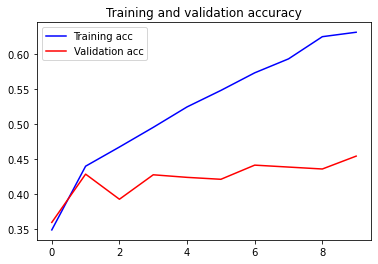

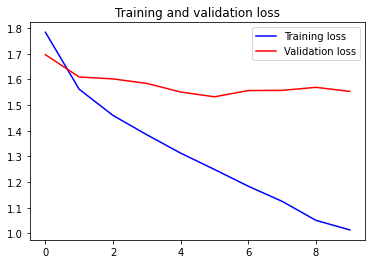

In [13]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "b", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "b", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [14]:
def get_best_model(bm):
    _, score, _ = bm.name.split('.')
    return int(score)

import os
import cv2
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if any([filename.endswith(x) for x in ['.png']]):
            img = cv2.imread(os.path.join(folder, filename))
            if img is not None:
                images.append(img)
    return images

folders = [
    'anger',
    'contempt',
    'disgust',
    'fear',
    'happiness',
    'neutrality',
    'sadness',
    'surprise'
]

for folder in folders:
    images = load_images_from_folder(folder)
    images = cv2.cvtColor(images,cv2.COLOR_GRAY2RGB)

In [15]:
best_score = 0, ""
for best_model in Path(".").glob("*.hdf5"):
    score = get_best_model(best_model)
    if score > best_score[0]:
        best_score = score, best_model
best_score

(454, PosixPath('best_model_0.454.hdf5'))

In [16]:
model = tf.keras.models.load_model(best_score[1])

In [17]:
# Make predictions on the test data
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Print the predicted class probabilities for the first 10 samples
print(predictions[:10])

# Get the predicted classes for the test data
predicted_classes = np.argmax(predictions, axis=1)

# label the predictions
label_map = train_generator.class_indices
label_map = dict((v, k) for k, v in label_map.items())  # flip k,v
labeled_predictions = [label_map[k] for k in predicted_classes]
# Print the predicted classes for the first 10 samples
print(labeled_predictions[:10])

55/55 [==============================] - 51s 913ms/step
[[2.34476896e-03 1.42421541e-05 1.05704553e-03 6.19664341e-02
  2.49653216e-02 5.09502017e-04 1.26886903e-03 9.07873809e-01]
 [3.35579775e-02 2.33662291e-03 1.36760874e-02 4.88455780e-02
  2.90764689e-01 4.55523208e-02 1.60969477e-02 5.49169779e-01]
 [8.99045840e-02 1.57967042e-02 7.52775297e-02 8.99539292e-02
  5.30901924e-02 3.99956733e-01 2.06314012e-01 6.97062835e-02]
 [2.17954032e-02 2.24191579e-04 3.81557755e-02 4.67573017e-01
  2.61918106e-03 1.04802917e-03 1.20865181e-02 4.56497729e-01]
 [1.50495814e-03 4.24566424e-05 2.68784259e-03 2.89198011e-02
  4.02908074e-03 1.24091050e-03 9.51999605e-01 9.57519095e-03]
 [3.05630416e-01 4.34913971e-02 3.67106944e-02 2.64391620e-02
  2.44469360e-01 2.42971689e-01 4.15226370e-02 5.87646477e-02]
 [6.70173645e-01 9.03656520e-03 2.67838612e-02 1.23630520e-02
  3.87367862e-03 4.20963466e-02 1.36106759e-01 9.95659381e-02]
 [6.68942258e-02 1.01054423e-02 1.62799209e-02 3.20522743e-03
  8.795

In [18]:
images = test_generator.filenames
results = pd.DataFrame(
    {"label": labeled_predictions, "image": images}, columns=["label", "image"]
)
results["image"] = results["image"].apply(lambda x: x.split(".")[0])
results.sample(10)

,label,image
1639,disgust,surprise/images - 2020-11-06T203715
994,sadness,happiness/images - 2020-11-06T194613
1742,sadness,surprise/images - 2020-11-06T203938
196,surprise,anger/images - 2020-11-06T201648
544,anger,fear/images - 2020-11-06T203327
1120,anger,neutrality/images - 2020-11-06T182428
772,surprise,happiness/images - 2020-11-06T193958
948,happiness,happiness/images - 2020-11-06T194546
619,surprise,happiness/images (30)_face
576,disgust,fear/images - 2020-11-06T203444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


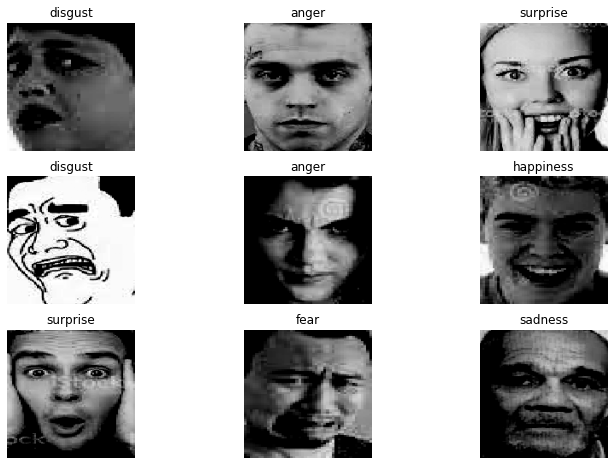

In [19]:
plt.figure(figsize=(12, 8))

for x in range(9):
    images, labels = next(test_generator)
    image = images[0]
    idx = np.where(labels[0] == 1.)[0][0]
    label = label_map[idx]
    plt.subplot(3, 3, x + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()

In [9]:
model = keras.models.load_model('best_model_0.454.hdf5')

In [10]:
image_size = (150, 150)

In [11]:
# Load the test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_generator = test_datagen.flow_from_directory(
    'human_emotion_classification/archive/val',
    target_size=(img_height, img_width),
#     color_mode='grayscale',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
)

Found 1750 images belonging to 8 classes.


In [13]:
model.evaluate(test_generator)

55/55 [==============================] - 51s 904ms/step - loss: 0.9165 - accuracy: 0.6851


[0.9165338277816772, 0.6851428747177124]